Lets work with sample data.

In [98]:
from torch.utils.data import Dataset, DataLoader

In [99]:
# !unzip ../input/diabetic-retinopathy-detection/sample.zip
# !unzip ../input/diabetic-retinopathy-detection/sampleSubmission.csv.zip

In [100]:
# ! dir sample

In [101]:
# !unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip

In [102]:
# from PIL import Image

# img = Image.open("./sample/16_right.jpeg")

# import matplotlib.pyplot as plt

# plt.imshow(img)

But there are no labels!

In [103]:
# import pandas as pd

# pd.read_csv("./trainLabels.csv")

Lets get the first train file

In [104]:
#!mv ../input/diabetic-retinopathy-detection/train.zip.001 ./train1.zip

In [105]:
# !unzip train1.zip

# I guess we need to find something else altogether

# New dataset , diabetic-retinopathy-resized

In [106]:
pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels.csv")['level'].unique()

# classes

array([0, 1, 2, 4, 3])

In [107]:
import os
cropped = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels_cropped.csv")[:5000]

In [108]:
cropped.iloc[0]

Unnamed: 0            0
Unnamed: 0.1          0
image           10_left
level                 0
Name: 0, dtype: object

In [109]:
image_names = os.listdir("../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/")
image_names.sort()
image_names[:5]

['10003_left.jpeg',
 '10003_right.jpeg',
 '10007_left.jpeg',
 '10007_right.jpeg',
 '10009_left.jpeg']

In [110]:
images_path = "../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
img_path = os.path.join(images_path, cropped.iloc[3500].image+".jpeg")
img_path

'../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/4380_left.jpeg'

(1024, 1024)

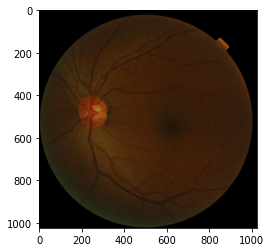

In [111]:
img = Image.open(img_path)

plt.imshow(img)

img.size

In [112]:
import torchvision.transforms as transforms
my_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [113]:
import torch

class retinaDataset(Dataset):
    def __init__(self, imagepath="../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped", total=None,transform=my_transform):
        self.df = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels_cropped.csv")
        
        if (total is not None):
            self.df = self.df[:total]
        
        self.transform = transform
        
        self.imagepath = imagepath
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.imagepath, self.df.iloc[index].image +".jpeg")
        img = Image.open(img_path)
        
        if(self.transform):
            img = self.transform(img)
        
        return img, torch.tensor(self.df.iloc[index].level)


In [114]:
train_dataset = retinaDataset(total=5000)

(torch.Size([3, 299, 299]), tensor(0), 5000)

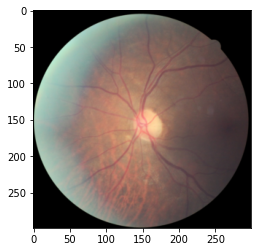

In [115]:
img, label = train_dataset[0]

plt.imshow(img.permute(1,2,0))
img.shape, label, train_dataset.__len__()

In [116]:
num_classes = 5
learning_rate = 1e-4
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
from torchvision.models import inception_v3

model = inception_v3(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [118]:
model.fc = torch.nn.Linear(in_features=2048, out_features=5, bias=True)

In [119]:
model.aux_logits = False

In [120]:
model = model.to(device=device)

In [121]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [122]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

In [123]:
batch_size = 32

In [124]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [127]:
from tqdm import tqdm

for epoch in range(num_epochs):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        optimizer.zero_grad()
        
        loss = loss_criterion(score, target)
        loss.backward()
        
        optimizer.step()
    
    print(f"for epoch {epoch}, loss : {loss}")
    

100%|██████████| 157/157 [18:24<00:00,  7.04s/it]

for epoch 0, loss : 0.8309454917907715


In [129]:
def check_accuracy(model, loader):
    model.eval()
    
    correct_output = 0
    total_output = 0
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")

In [130]:
check_accuracy(model, train_dataloader)

100%|██████████| 157/157 [17:09<00:00,  6.56s/it]

out of 5000 , total correct: 3659 with an accuracy of 73.18000197410583


predicted:  tensor([0])
actual:  7979    0
Name: level, dtype: int64


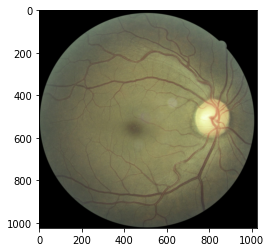

In [163]:
image = Image.open("../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/10007_right.jpeg")

img = my_transform(image).unsqueeze(0)

score = model(img)

_, predictions = score.max(1)

plt.imshow(image)

print("predicted: ", predictions)

df = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels_cropped.csv")

# print(df[image][:5])
# print(df.loc[df[image]=="10_left"].level)
print("actual: ", df.loc[df['image'].isin(['10007_right'])].level)
